In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import scipy.stats as stats

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.mpl.ticker as cticker

import cmocean

from plotting import *

In [2]:
#anomaly matrix files: seasonal cycle has been removed
u_anom_file = './data/u_anom_7917.npy'
v_anom_file = './data/v_anom_7917.npy'
t_anom_file = './data/t_anom_7917.npy'

#variable files on disk
lon_file = './data/lon.npy'
lat_file = './data/lat.npy'
p_file = './data/p.npy'
time_file = './data/time.npy'

pc1_filt_file = './data/pc1_filt_all_months.npy'
pc2_filt_file = './data/pc2_filt_all_months.npy'

#set colormap here
colormap = cmocean.cm.balance

#set projection and central longitude for plotting purposes
central_lon = -90
proj = ccrs.PlateCarree(central_longitude=central_lon)
trans = ccrs.PlateCarree()

#for labelling plots
lon_list = [90, 120, 150, 180, -150, -120, -90, -60, -30, 0, 30, 60, 90]
lat_list = [-90, -60, -30, 0, 30, 60, 90]

temp_ = 'temperature'
U_ = 'U-Wind'
V_ = 'V-Wind'

djf = ', DJF'
mam = ', MAM'

In [3]:
#read in data files
t_anom = np.load(t_anom_file)
u_anom = np.load(u_anom_file)
v_anom = np.load(v_anom_file)

pc1_filt = np.load(pc1_filt_file)
pc2_filt = np.load(pc2_filt_file)

lon = np.load(lon_file)
lat = np.load(lat_file)
p = np.load(p_file)
time = np.load(time_file)
dates = pd.to_datetime(time)

In [4]:
#pressure level at which we want to subset
#850:30, 500:21, 200:14
pidx = 14

#are we planning on using pc1 or pc2?
pc = 'PC2'

#select season here
season = djf

#months corresponding to "season"
if season == djf:
    months = [12, 1, 2]

elif season == mam:
    months = [2, 3, 4]
#we only care about djf and mam
else:
    raise ValueEror('We are not analyzing that season!')

#for left plot title
#we are doing this after loading in the data so that we can access the pressure array
left_title_idx_tstat = 'T Statistic, Shallow Index Anomaly Subset, {}, {}, {} hPa, '.format(pc, season[2:], str(int(p[pidx])))

#filenmaes for saving
figname_temp = 'temp_shallow_mean_{}_{}_{}'.format(pc, season[2:], str(int(p[pidx])))
figname_u = 'u_shallow_mean_{}_{}_{}'.format(pc, season[2:], str(int(p[pidx])))
figname_v = 'v_shallow_mean_{}_{}_{}'.format(pc, season[2:], str(int(p[pidx])))

_tstat_contours = '_tstat_contours.pdf'

### Compositing
A [composite analysis](https://en.wikipedia.org/wiki/Superposed_epoch_analysis), also known as superposed epoch analysis, can be used to compare a signal found in a subset of your data to that of the whole data set. For our purposes, we will be comparing the means of different subsets of normalized variables (temperature, U-wind, V-wind) against that of the whole normalized variable by running a t-test. This significance test will tell us how likely our subset's spatial structure is given a particular significance level. But before we can subset our data, we need to define some indices based off our filtered Principal Component time series. If our PCs are below some threshold (less than some negative value), then we would expect more upward pressure velocity in the Eastern Pacific (since that is where we subset for)

In this Notebook, we are only going to examine temperature and the U- and V- components of the wind. Before we also included $\omega$ and specific humidity, but specific humidity should follow temperature and $\omega$ is highly variable and scattered. Thus, we will examine three of the most common atmospheric variables at three common pressure levels: 850, 500, and 200 hPa.

### Create shallow index

Below we are going to create what I am calling a 'shallow index' by setting a threshold value for the filtered PC1 and PC2. But first, let's remind ourselves of what those time series look like.

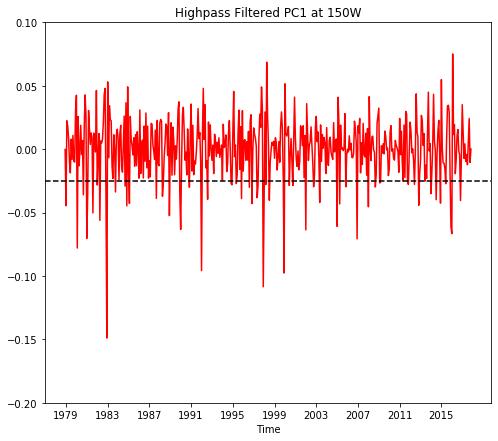

In [5]:
#plot filtered pc1 with threshold value
plot_pcs(pc1_filt, dates.month, dates.year, 'Highpass Filtered PC1 at 150W', [-0.2, 0.1], True, -0.025)

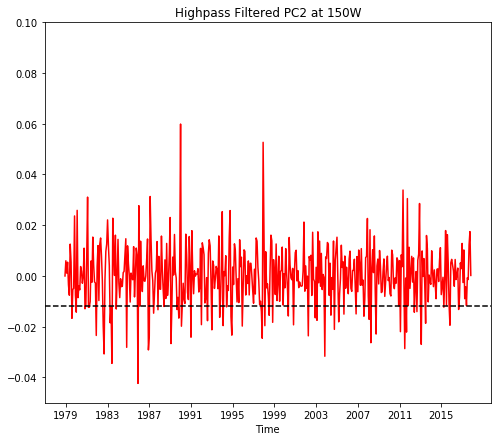

In [6]:
#plot pc2 with threshold value
plot_pcs(pc2_filt, dates.month, dates.year, 'Highpass Filtered PC2 at 150W', [-0.05, 0.1], True, -0.012)

In [7]:
#calculate the standard deviation of the time series for choosing threshold value
pc1_filt_std = np.std(pc1_filt)
pc2_filt_std = np.std(pc2_filt)

#round variables for printing
std_pc1_print = np.round(pc1_filt_std, 5)
std_pc2_print = np.round(pc2_filt_std, 5)

print('1 standard deviation away from the mean for the filtered PC1 time series is {}.'.format(std_pc1_print))
print('2 standard deviations away from the mean for the filtered PC1 time series is {}.'.format(std_pc1_print*2), '\n')

print('1 standard deviation away from the mean for the filtered PC2 time series is {}.'.format(std_pc2_print))
print('2 standard deviations away from the mean for the filtered PC2 time series is {}.'.format(std_pc2_print*2), '\n')

1 standard deviation away from the mean for the filtered PC1 time series is 0.02505.
2 standard deviations away from the mean for the filtered PC1 time series is 0.0501. 

1 standard deviation away from the mean for the filtered PC2 time series is 0.01196.
2 standard deviations away from the mean for the filtered PC2 time series is 0.02392. 



The threshold values on the time series are ~1 standard deviation away from the mean of the entire time series. Our answer from the compositing analyis, if it is robust, will not change drastically if we go up to 1.5 or even 2 standard deviations. We can always play with different values later.

In [8]:
#shallow indices, dates where pcs are 
#mean + std away from average value
shallow_idx1 = np.where(pc1_filt <= -0.025)[0]
shallow_idx2 = np.where(pc2_filt <= -0.012)[0]

In [9]:
print(len(shallow_idx1))
print(shallow_idx1, '\n')
      
print(len(shallow_idx2))
print(shallow_idx2, '\n')

62
[  1  14  21  25  26  32  37  40  47  48  58  69  71  74 105 112 113 120
 132 133 143 157 164 191 192 197 203 212 215 221 222 228 229 231 235 252
 258 262 277 286 293 313 316 323 336 349 357 362 363 389 394 395 402 407
 414 421 427 432 438 444 445 455] 

63
[  8  13  23  27  28  36  44  45  52  53  54  59  71  84  96  97 102 107
 114 122 129 131 134 145 157 164 169 178 182 186 191 192 204 226 227 230
 235 239 257 263 280 288 290 299 306 310 315 321 335 344 350 352 358 386
 391 393 402 405 410 415 436 443 453] 



### Subset for time

If you are curious about why we are only subsetting for certain seasons (or more specifically why we are interested in DJF), I encourage you to visit the [find_monthly_distribution](https://github.com/Jakidxav/shallow_tropical_convection/blob/master/find_monthly_distribution.ipynb) Notebook for more information.

In [10]:
#create a time indexer array; we could change the months out for different seasons in the above "months" list
tidx = np.logical_or(dates.month==months[0], np.logical_or(dates.month==months[1], dates.month==months[2]))

#which indices correspond to djf?
print(np.where(tidx)[0])

[  0   1  11  12  13  23  24  25  35  36  37  47  48  49  59  60  61  71
  72  73  83  84  85  95  96  97 107 108 109 119 120 121 131 132 133 143
 144 145 155 156 157 167 168 169 179 180 181 191 192 193 203 204 205 215
 216 217 227 228 229 239 240 241 251 252 253 263 264 265 275 276 277 287
 288 289 299 300 301 311 312 313 323 324 325 335 336 337 347 348 349 359
 360 361 362 363 382 383 384 385 395 396 397 407 408 409 419 420 421 431
 432 433 443 444 445 455 456 457 467]


In [11]:
#both winter months and threshold values of pc1
djf_and_pc1 = sorted(list(set(shallow_idx1) & set(np.where(tidx)[0])))
print(len(djf_and_pc1))

32


In [12]:
#both winter months and threshold values of pc2
djf_and_pc2 = sorted(list(set(shallow_idx2) & set(np.where(tidx)[0])))
print(len(djf_and_pc2))

23


In [13]:
"""
Enter in indices of months you want to subset for, and get out a subset of the data
where the months are both in a season (DJF, MAM, etc) AND they occur below some threshold value.
This method assumes that time is in the first axis (axis 0).
"""
def season_and_threshold(anom, season_pc_idx):
    
    return anom[season_pc_idx]

In [14]:
#re-route for if we are using PC1 or PC2 subsets dates
if pc == 'PC1':
    djf_and_pc = djf_and_pc1
else:
    djf_and_pc = djf_and_pc2

#let's look at pc2 data first
t_anom = season_and_threshold(t_anom, djf_and_pc)
u_anom = season_and_threshold(u_anom, djf_and_pc)
v_anom = season_and_threshold(v_anom, djf_and_pc)

In [15]:
#does our data have the right shape?
#pc1: (32, ...), pc2: (23, ...)
print(np.shape(t_anom))
print(np.shape(u_anom))
print(np.shape(v_anom))

(23, 37, 121, 240)
(23, 37, 121, 240)
(23, 37, 121, 240)


### Critical t-value, Autocorrelation, DOF

In [16]:
#def shallow_idx_anom(anom, shallow_idx, tidx):
def shallow_idx_anom(anom, shallow_idx):
    #create shallow index anomaly
    #that is, subset anomaly for when shallow circulation index is below certain threshold
    #anom_shallow = anom[shallow_idx]i
    anom_shallow = anom

    #average over time, now shape is (pressure, lat, lon) = (37, 121, 240)
    anom_shallow_mean = np.mean(anom_shallow, axis=0)

    #compute standard deviation over time, now shape is (pressure, lat, lon) = (37, 121, 240)
    anom_shallow_std = np.std(anom_shallow, axis=0)

    #number of months in anomaly subset
    N = len(anom_shallow)
    
    return N, anom_shallow, anom_shallow_mean, anom_shallow_std

In [17]:
#re-route for if we are using shallow index from PC1 or PC1
if pc == 'PC1':
    shallow_idx = shallow_idx1
else:
    shallow_idx = shallow_idx2
    
N2, t_anom_shallow, t_anom_shallow_mean, t_anom_shallow_std = shallow_idx_anom(t_anom, shallow_idx)
N3, u_anom_shallow, u_anom_shallow_mean, u_anom_shallow_std = shallow_idx_anom(u_anom, shallow_idx)
N4, v_anom_shallow, v_anom_shallow_mean, v_anom_shallow_std = shallow_idx_anom(v_anom, shallow_idx)

In [18]:
t_anom_shallow.shape

(23, 37, 121, 240)

### Calculating DOF using autocorrelation

In [19]:
#calculate autocorrelation and degrees of freedom given a variable of length n
def autocorr_dof(var, n):

    reshape = np.reshape(var, (n, -1))

    #create matrices that are 1 month apart
    reshape1 = reshape[:-1]
    reshape2 = reshape[1:]

    #autocorrelation of sst for one month time lag
    #element-wise multiply our two 1-month lag matrices, sum over all dimensions
    top = np.sum(np.multiply(reshape1, reshape2))

    #element-wise multiply the sum of the squared 1-month time lag matrices, take square root
    bottom = np.sqrt(np.multiply(np.sum(reshape1**2), np.sum(reshape2**2)))

    #calculate autocorrelation
    autt = top / bottom

    #calculate degrees of freedom for all months
    dof = n * (1 - autt*autt) / (1 + autt*autt)
    
    return autt, dof

In [20]:
#calculate autocorr and dof for t, u, v
auto2, dof2 = autocorr_dof(t_anom_shallow, N2)
auto3, dof3 = autocorr_dof(u_anom_shallow, N3)
auto4, dof4 = autocorr_dof(v_anom_shallow, N4)

### t-test
For every point in our subset anomaly matrix, this is calculated with:

$$t = \frac{\mu_x * \sqrt{N - 1}}{\sigma_x}$$

Normally, we would have to subtract the mean of the whole data set from $\mu_x$, but we have designed the analysis such that we can ignore this term (since the mean of a normalized variable is by definition 0).

In [21]:
#given a significance level, degrees of freedom, mean, standard deviation, and length of a matrix
#calculate a t-statistic array of the same shape as well as the critical t-value for that test
def t_test(sig, dof, var_mean, var_std, n):
    #calculate critical t value to compare against at 95% confidence for N data points
    critical_t = stats.t.ppf(q=sig, df=dof)

    #convert critical t value to string for plotting
    critt_str = str(np.round(critical_t, 3))

    #t-test
    tstat = np.divide((var_mean * np.sqrt(n - 1)), var_std)
    
    return tstat, critical_t, critt_str

In [22]:
#t-test
tstat2, critical_t2, critt_str2 = t_test(0.975, dof2, t_anom_shallow_mean, t_anom_shallow_std, N2)
tstat3, critical_t3, critt_str3 = t_test(0.975, dof3, u_anom_shallow_mean, u_anom_shallow_std, N3)
tstat4, critical_t4, critt_str4 = t_test(0.975, dof4, v_anom_shallow_mean, v_anom_shallow_std, N4)

In [23]:
#find the miniminum and maxiumum values for an array, construct normalized contour from them
def get_min_max_contours(var):
    min_ = np.min(var)
    max_ = np.max(var)
    
    if np.abs(min_) > max_:
        step = np.abs(min_) / 100
        vmin = min_
        vmax = -vmin
        
    else:
        step = max_ / 100
        vmin = -max_
        vmax = max_
    
    contours = np.arange(vmin, vmax, step)
    
    return vmin, vmax, contours, step

In [24]:
#get min, max, contours
vmint, vmaxt, cont, stept = get_min_max_contours(tstat2)
vminu, vmaxu, conu, stepu = get_min_max_contours(tstat3)
vminv, vmaxv, conv, stepv = get_min_max_contours(tstat4)

One note about plotting here: while in previous (and future) Notebooks, blue has meant upward pressure velocity, here we are simply plotting the t-statistic. So while these structures mimic those of the real variables in question (temperature, wind-components, etc.), they are statistical values.

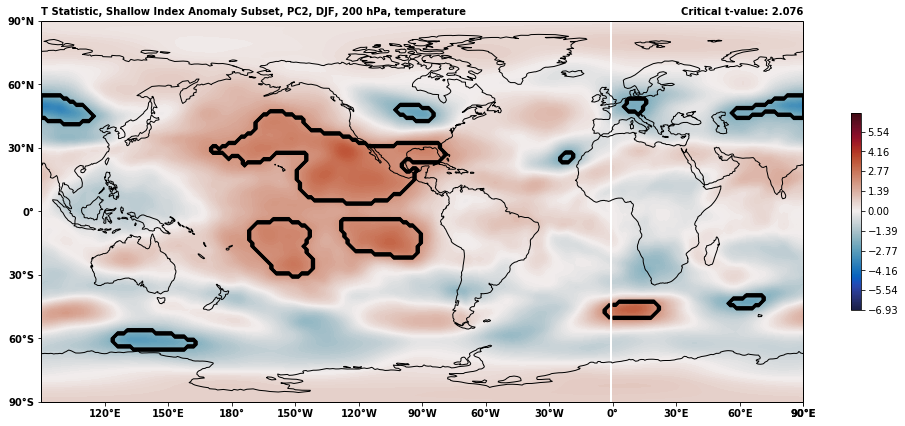

In [25]:
#temperature
plot_field_tstat(proj, trans, central_lon, lon, lat, tstat2[pidx], critical_t2, vmint, vmaxt, cont, colormap, lon_list, lat_list,
                   left_title_idx_tstat+temp_, 'Critical t-value: '+critt_str2, figname_temp+_tstat_contours, False)

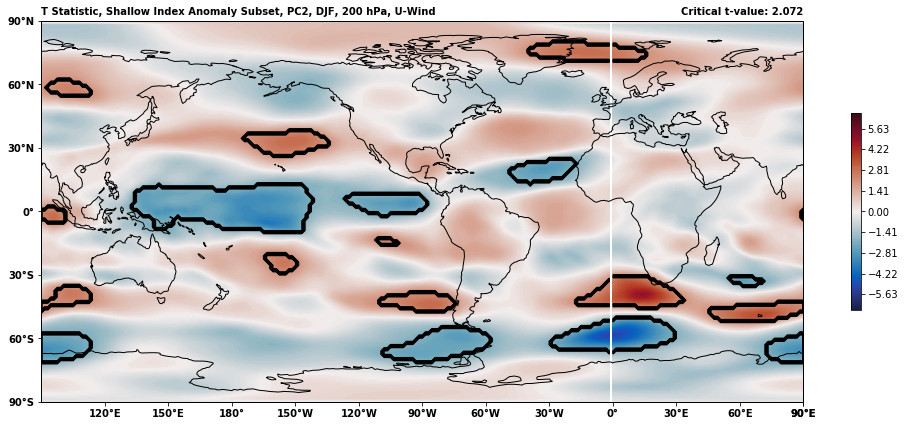

In [26]:
#v-wind
plot_field_tstat(proj, trans, central_lon, lon, lat, tstat3[pidx], critical_t3, vminu, vmaxu, conu, colormap, lon_list, lat_list,
                   left_title_idx_tstat+U_, 'Critical t-value: '+critt_str3, figname_u+_tstat_contours, False)

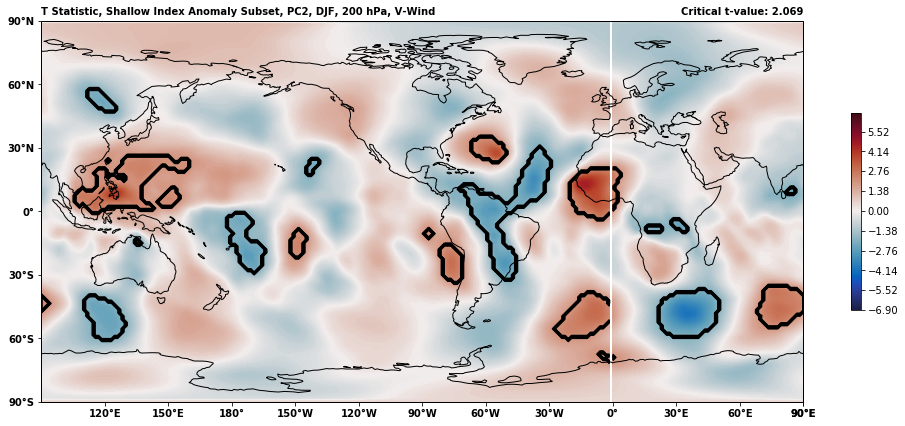

In [27]:
#u-wind
plot_field_tstat(proj, trans, central_lon, lon, lat, tstat4[pidx], critical_t4, vminv, vmaxv, conv, colormap, lon_list, lat_list,
                   left_title_idx_tstat+V_, 'Critical t-value: '+critt_str4, figname_v+_tstat_contours, False)

We notice that the dates given by thresholding our filtered PC2 time series leads to more spatially-significant patterns. We have looked at 850, 500, and 200 hPa and see that 200 hPa is the most signicant across fields like temperature, U-wind, and V-wind. There is some sort of temperature and wind anomaly higher up in the atmosphere. Thus, in the next Notebook, I will focus on the PC2 filtered time series for the same three pressure levels and the same three variables that I examined in this analysis.